# Cash Ratio Optimization BRI Challenge

- Starting data from 2020 does not increase performance
- Already did some parameter tuning. Haventsubmitted yet.

adding these does not increase performance.
- 'holidays_prior_scale':  [0.0001, 0.001, 0.01, 0.1, 1],
- 'seasonality_mode':  ['additive', 'multiplicative']

In [1]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,  timedelta

from fbprophet.diagnostics import performance_metrics

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./Data/train.csv')
df.head(6)

,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09
5,2019-08-05,1.243150e+09,-1.488550e+09,1.528018e+11,-1.362008e+11,3.0,1.128248e+12,8.245192e+11,1.217677e+10,6.655014e+11,3.135744e+11,2.774827e+11,3.628850e+09


In [3]:
# Find features with missing values and understand the missing values ratio.
def check_na(df):
    nas =  pd.DataFrame([(x, df[x].isnull().sum()*100/len(df)) for x in df]).rename(columns= {0: 'Nas_Features' , 1:'Missing Values Ratio'})
    
    if nas['Missing Values Ratio'].sum() == 0:
        print('No Missing Values Found.')
    else:
        return nas[nas['Missing Values Ratio'] != 0]
check_na(df)

No Missing Values Found.


# Exploratory Data Analysis

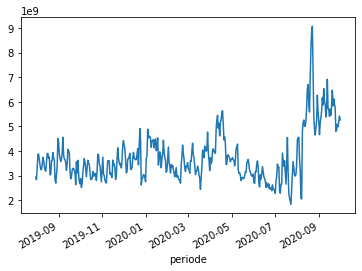

In [4]:
df['periode'] = [datetime.strptime(x, "%Y-%m-%d") for x in df.loc[:, 'periode']]
df.set_index('periode')['kas_echannel'].plot();

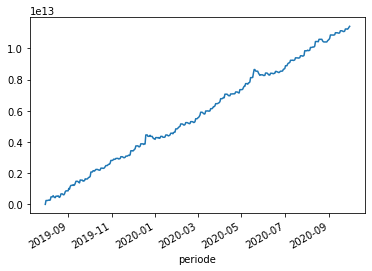

In [5]:
df.set_index('periode')['kas_kantor'].plot();

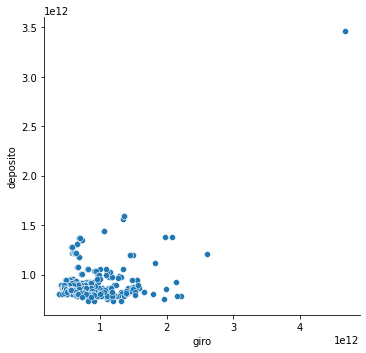

In [6]:
sns.relplot(x = 'giro', y = 'deposito', data = df);

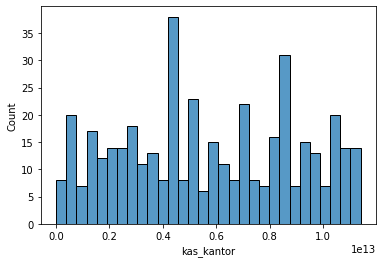

In [7]:
sns.histplot(df['kas_kantor'], bins=30);

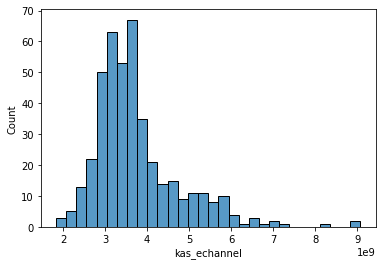

In [8]:
sns.histplot(df['kas_echannel'], bins=30);

# *Modelling*

## *FBProphet*

In [9]:
df = df[df['periode'] > '2019']

In [10]:
df_kas_kantor = df[['periode', 'kas_kantor']]
df_kas_echannel = df[['periode', 'kas_echannel']]

df_kas_kantor.columns = ['ds', 'y']
df_kas_echannel.columns = ['ds', 'y']

In [ ]:
param_grid = { 
    'changepoint_prior_scale': np.arange(0.00029, 0.00031, 0.00001), # Results from Parameter tuning    
    'seasonality_prior_scale': np.arange(0.893, 0.896, 0.001), # Results from Parameter tuning
    'holidays_prior_scale': [10**-7, 10**-6, 5*10**-6]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

cutoffs = pd.to_datetime(['2020-08-01'])

for params in all_params:
    m = Prophet(**params, 
                yearly_seasonality= True,
                daily_seasonality= True).fit(df_kas_kantor)  # Fit model with given params
    
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '30 days', parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
all_params[np.argmin(rmses)]

In [ ]:
all_params[np.argmin(rmses)]

In [ ]:
param_grid2 = { 
    'growth': ['linear'], 
    'changepoint_prior_scale': np.arange(0.68, 0.70, step = 0.01),
    'seasonality_prior_scale': np.arange(7.3, 7.5, step = 0.1),
    'holidays_prior_scale':  [10**-9, 10**-8,10**-6]
}

# Generate all combinations of parameters
all_params2 = [dict(zip(param_grid2.keys(), v)) for v in itertools.product(*param_grid2.values())]
rmses2 = []

cutoffs2 = pd.to_datetime(['2020-08-01'])

for params in all_params2:
    m2 = Prophet(**params, 
                 yearly_seasonality= True,
                 daily_seasonality= True).fit(df_kas_echannel)  # Fit model with given params
    
    df_cv2 = cross_validation(m2, cutoffs=cutoffs2, horizon='30 days', parallel="processes")
    df_p2 = performance_metrics(df_cv2, rolling_window=1)
    rmses2.append(df_p2['rmse'].values[0])

# Find the best parameters
tuning_results2 = pd.DataFrame(all_params2)
tuning_results2['rmse'] = rmses2
print(tuning_results2)

In [ ]:
all_params2[np.argmin(rmses2)]

In [18]:
# define the model
ts_kas_kantor = Prophet(yearly_seasonality= True,
                        daily_seasonality= True,
                        weekly_seasonality = True,
                        changepoint_prior_scale = 0.0003,
                        seasonality_prior_scale = 0.89, 
                        holidays_prior_scale = 0.001, 
                        seasonality_mode = 'additive')

ts_kas_echannel = Prophet(yearly_seasonality= True,
                          daily_seasonality= True,
                          weekly_seasonality = True,
                          changepoint_prior_scale = 0.7, 
                          seasonality_prior_scale = 7.5, 
                          holidays_prior_scale = 0.005,
                          seasonality_mode = 'additive')

# fit the model
ts_kas_kantor.fit(df_kas_kantor);
ts_kas_echannel.fit(df_kas_echannel);


### This exact settings produce 0.06603

### FBProphet Predicting Process

In [12]:
future_kas_kantor = ts_kas_kantor.make_future_dataframe(freq = 'D', periods = 31)
future_kas_echannel = ts_kas_echannel.make_future_dataframe(freq = 'D', periods = 31)

In [13]:
forecast_kas_kantor = ts_kas_kantor.predict(future_kas_kantor)
forecast_kas_echannel = ts_kas_echannel.predict(future_kas_echannel)

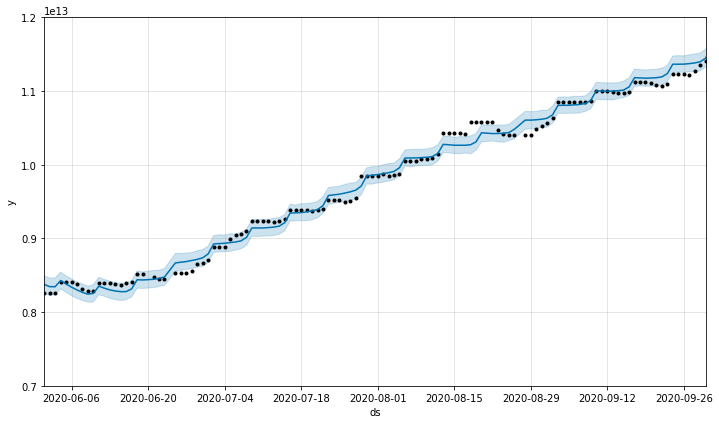

In [14]:
fig = ts_kas_kantor.plot(forecast_kas_kantor)

ax = fig.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-06-01', '2020-09-30'])) 
# we can ignore the shadow part by setting y limit
ax.set_ylim([0.7*10**13, 1.2*10**13]) 
plt.show()

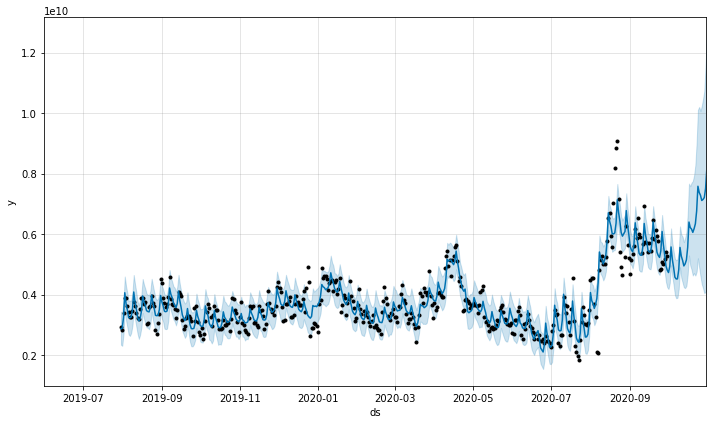

In [15]:
fig2 = ts_kas_echannel.plot(forecast_kas_echannel)

ax2 = fig2.gca()
# setting x limit. date range to plot
ax2.set_xlim(pd.to_datetime(['2019-06-01', '2020-10-30'])) 
# we can ignore the shadow part by setting y limit
# ax2.set_ylim([0.9*10**13, 1.2*10**13]) 
plt.show()

## *ARIMA*

In [ ]:
import pmdarima
import statsmodels.tsa.api as smt

In [ ]:
df['periode'] = pd.to_datetime(df['periode'],  format = '%Y-%m-%d')

In [ ]:
# ts object

ts_kas_kantor = pd.Series(data = [x for x in df['kas_kantor']], index = df['periode'])

In [ ]:
'''
Split train/test from any given data point.
:parameter
    :param ts: pandas Series
    :param test: num or str - test size (ex. 0.20) or index position
                 (ex. "yyyy-mm-dd", 1000)
:return
    ts_train, ts_test
'''
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

In [ ]:
ts_train, ts_test = split_train_test(ts_kas_kantor, test = "2020-01-01")

In [ ]:
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

In [ ]:
best_model = pmdarima.auto_arima(ts_kas_kantor,                                    
                                 seasonal=True, stationary=False, 
                                 m=7, information_criterion='aic', 
                                 max_order=20,                                     
                                 max_p=10, max_d=3, max_q=10,                                     
                                 max_P=10, max_D=3, max_Q=10,                                   
                                 error_action='ignore')
print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)

In [ ]:
def fit_sarimax(ts_train, ts_test, order=(1,0,1), 
                seasonal_order=(0,0,0,0), exog_train=None, 
                exog_test=None, figsize=(15,10)):
    ## train
    model = smt.SARIMAX(ts_train, order=order, 
                        seasonal_order=seasonal_order, 
                        exog=exog_train, enforce_stationarity=False, 
                        enforce_invertibility=False).fit()
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.predict(start=len(ts_train), 
                            end=len(ts_train)+len(ts_test)-1, 
                            exog=exog_test)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "ARIMA "+str(order) if exog_train is None else "ARIMAX "+str(order)
    title = "S"+title+" x "+str(seasonal_order) if np.sum(seasonal_order) > 0 else title
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, title=title)
    return dtf, model

In [ ]:
dtf, model = fit_sarimax(ts_train, ts_test, order=(1,1,0), 
                         seasonal_order=(7,0,2,7))

# Prediction on Test Data

In [16]:
ans = pd.DataFrame(pd.concat([forecast_kas_kantor['yhat'][-31:], forecast_kas_echannel['yhat'][-31:]])).reset_index(drop = True)
# ans.drop('index', axis = 1, inplace = True)
ans.rename(columns = {'yhat': 'value'}, inplace =True)
ans = ans.reset_index().set_index('index')

In [17]:
ans.to_csv('./Data/answer_cro.csv')
pd.read_csv('./Data/answer_cro.csv')

,index,value
0,0,1.158040e+13
1,1,1.158493e+13
2,2,1.159088e+13
3,3,1.160186e+13
4,4,1.161467e+13
...,...,...
57,57,7.109000e+09
58,58,7.145696e+09
59,59,7.207581e+09
60,60,7.510610e+09
